In [1]:
## Imports the required libraries 

from scipy.stats import chi2 as chi2_scp
from cosmopower import cosmopower_NN
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
from numpy.linalg import inv
import tensorflow as tf
import numpy as np
import emcee
import gc

# Sets a random seed for reproducible results 
np.random.seed(100)

In [2]:
## Loads-in all required data 

reference_model_noisy = np.load("reference_model_noise.npy")
parameters = np.load("parameters.npz")
cov = np.load("cov_num_1500.npy")
models = np.load("models.npy")

# Computes the Hartlap factor 
h_1500 = (1500 - 1) / (1500 - len(reference_model_noisy) - 2)
# Computes the debiased inverse of the covariance matrix 
cov_inv = inv(cov) / h_1500

# Restores the trained model 
cp_nn_model = cosmopower_NN(restore = True, restore_filename = "emulator_final")
train_sample = np.arange(0, 7000)
# Selects 7000 rows from our model data for training 
train_features = np.load("models.npy")[train_sample]
minimum = np.min(train_features, axis = 0)
maximum = np.max(train_features - minimum, axis = 0)

In [5]:
list(parameters.keys())

['omega_m', 'omega_b', 'As', 'w']

In [3]:
# Specifies the length of the MCMC chain 
nsteps = 5000  
# Specifies the number of walkers in the MCMC chain 
nwalkers = 35
# Specifies the number of dimensions (4 since we are varying 4 parameters)
ndim = 4

## Computes various parameter values 

omega_m_vals = parameters["omega_m"]
omega_b_vals = parameters["omega_b"]
As_vals = parameters["As"]
w_vals = parameters["w"]

## Specifies prior bounds for all parameters

omega_m_bounds = [min(omega_m_vals), max(omega_m_vals)]
omega_b_bounds = [min(omega_b_vals), max(omega_b_vals)]
As_bounds = [min(As_vals), max(As_vals)]
w_bounds = [min(w_vals), max(w_vals)]
bounds = [omega_m_bounds, omega_b_bounds, As_bounds, w_bounds]

# Initiates an array that will contain different starting positions 
pos = np.empty((nwalkers, ndim))

for i in range(ndim):
    # Computes positions within a prior range according to a uniform distribution 
    vals = np.random.uniform(bounds[i][0], bounds[i][1], nwalkers)
    pos[:, i] = vals
    
def log_probability(theta):
    """
    Computes the log probability of certain parameter combinations. 
    """
    
    omega_m, omega_b, As, w = theta 
    
    # Checks if the parameter values are within their prior ranges 
    if omega_m_bounds[0] < omega_m < omega_m_bounds[1] and omega_b_bounds[0] < omega_b < omega_b_bounds[1] and As_bounds[0] < As < As_bounds[1] and w_bounds[0] < w < w_bounds[1]:
        
        # Makes a dictionary of parameter values 
        params = {"omega_m": [omega_m], "omega_b": [omega_b], "As": [As], "w": [w]}
        
        # Predicts the output of this parameter combination using the emulator 
        pred_vector = cp_nn_model.predictions_np(params)[0]
        pred_vector = pred_vector * maximum + minimum
        delta = pred_vector - reference_model_noisy
        # Compues the log probability, which is -chi^2 / 2
        likelihood = -0.5 * np.matmul(delta, np.matmul(cov_inv, delta))
        return likelihood
    
    # If a parameter is outside its prior range, then the log probability is - infinity 
    else: 
        return -np.inf 

In [4]:
# Initializes the walkers 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# Runs the MCMC 
sampler.run_mcmc(pos, nsteps, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:19<00:00,  7.36it/s]


State([[ 3.58605541e-01  5.20523390e-02  2.07927174e-09 -1.09343598e+00]
 [ 3.63567616e-01  5.17490962e-02  2.05012120e-09 -1.05850129e+00]
 [ 3.62894442e-01  5.35085168e-02  2.08229820e-09 -1.07984061e+00]
 [ 3.58277099e-01  4.87109124e-02  2.01494782e-09 -1.08998553e+00]
 [ 3.62570153e-01  5.17501413e-02  2.06340472e-09 -1.05972302e+00]
 [ 3.61177141e-01  5.00595454e-02  2.02007229e-09 -1.09584865e+00]
 [ 3.63418181e-01  5.29945808e-02  2.05887428e-09 -1.09187927e+00]
 [ 3.61212616e-01  4.82119178e-02  2.00075398e-09 -1.05927655e+00]
 [ 3.54783956e-01  4.47091232e-02  1.96825511e-09 -1.10099101e+00]
 [ 3.57508990e-01  5.07712002e-02  2.06912316e-09 -1.08677132e+00]
 [ 3.65794561e-01  5.55548085e-02  2.11235855e-09 -1.06105740e+00]
 [ 3.61471584e-01  5.03306892e-02  2.02798181e-09 -1.07250959e+00]
 [ 3.58057782e-01  5.06222261e-02  2.06307199e-09 -1.10915164e+00]
 [ 3.52495866e-01  4.71914016e-02  2.04522964e-09 -1.09489300e+00]
 [ 3.67411601e-01  5.66573570e-02  2.11561548e-09 -1.048

In [5]:
print("Mean acceptance fraction:", sampler.acceptance_fraction)
# Computes the autocorrelation time 
tau = sampler.get_autocorr_time(tol = 0)
print("Autocorrelation time:", tau) 
# Retrieves the parameter values for each walker at each step 
samples = sampler.get_chain()

Mean acceptance fraction: [0.6038 0.587  0.5996 0.5872 0.5916 0.6044 0.5862 0.6074 0.5948 0.5816
 0.5864 0.5982 0.5864 0.5956 0.584  0.5816 0.5866 0.5948 0.5938 0.5802
 0.6056 0.5922 0.5964 0.596  0.5894 0.578  0.5878 0.6094 0.603  0.5888
 0.5922 0.594  0.5978 0.594  0.5906]
Autocorrelation time: [28.99436043 44.41724239 43.58876334 37.51294808]


Text(0.5, 0, 'Step Number')

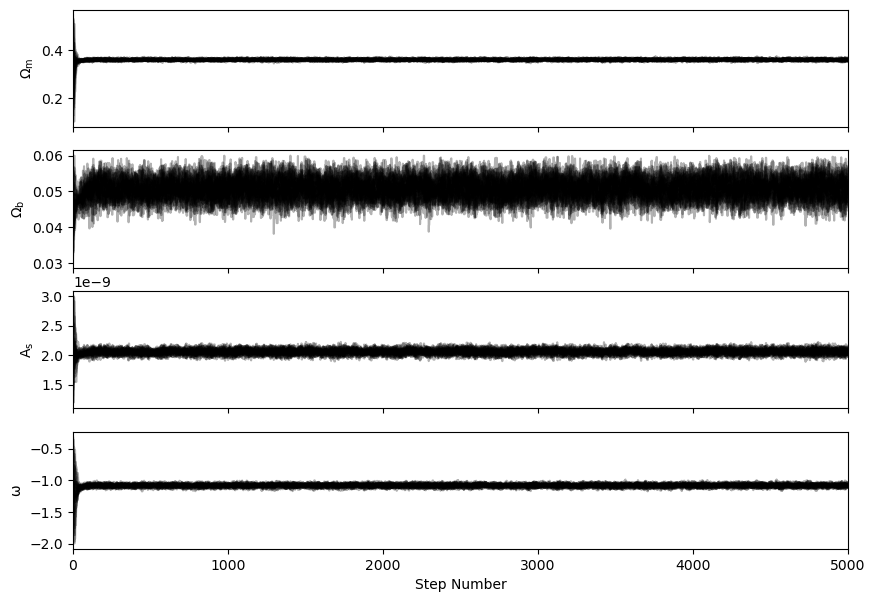

In [6]:
## Plots the parameter values for each walker at each step 

labels = [r"$\mathrm{\Omega_m}$", r"$\mathrm{\Omega_b}$", r"$\mathrm{A_s}$", 
          r"$\mathrm{\omega}$"]
fig, axes = plt.subplots(4, figsize = (10, 7), sharex = True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step Number")

Removed no burn in


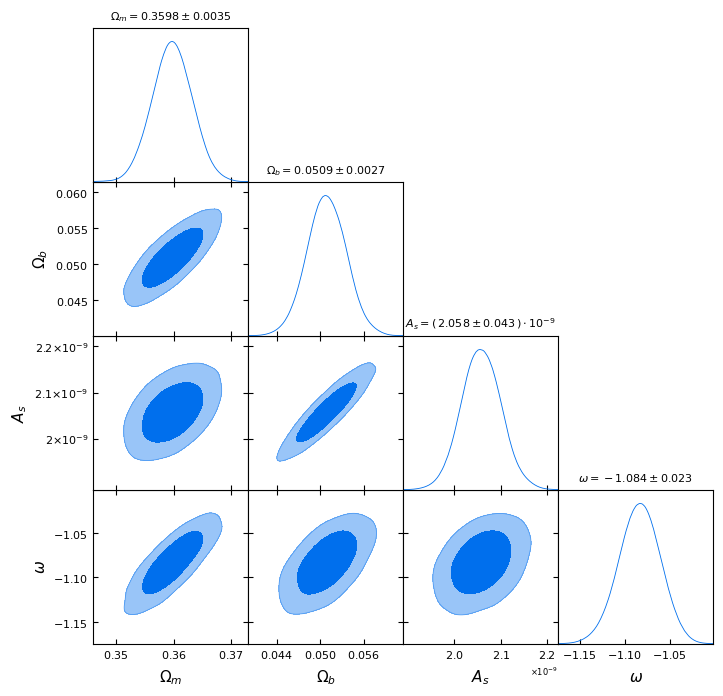

In [7]:
# Discards the burn-in steps, thins the chain, and flattens it 
flat_samples = sampler.get_chain(discard = 200, thin = 25, flat = True) 

## Plots the posterior probability distributions 

names = ["\Omega_m", "\Omega_b", "A_s", "\omega"]
samples = MCSamples(samples = flat_samples, names = names, labels = names)
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled = True, title_limit = 1)

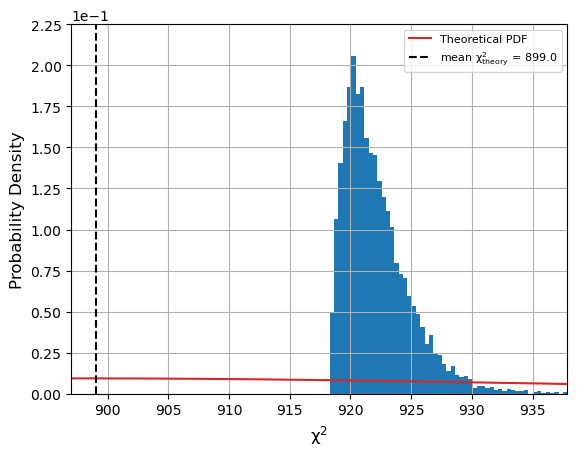

In [8]:
# Retrieves the log probabilities from the chain 
log_prob_samples = sampler.get_log_prob(discard = 200, thin = 25, flat = True)
# Computes the chi-squared values from the log probabilities 
chi2 = -2 * log_prob_samples

x_data = np.linspace(897, max(chi2), num = 10000)
# Computes the degrees of freedom (dof)
dof = len(reference_model_noisy) - 1
# Computes the theoretical mean and variance of the chi-squared distribution 
mean, var = chi2_scp.stats(dof, moments = "mv")

## Plots a histogram of the chi-squared values and the theoretical pdf

plt.hist(chi2, bins = "fd", density = True, color = "tab:blue")
# Computes the theoretical chi-squared distribution 
plt.plot(x_data, chi2_scp.pdf(x_data, dof), color = "tab:red", label = "Theoretical PDF")
plt.vlines(mean, 0, 0.225, label = "mean " + r"$\mathrm{\chi_{theory}^{2}}\,=\,$" + str(mean), 
           linestyle = "--", color = "k")
plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
plt.ylabel("Probability Density", fontsize = 12)
plt.xlim(897, max(chi2))
plt.ylim(0, 0.225)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
plt.legend(loc = "best", fontsize = 8)
plt.grid()
plt.show()

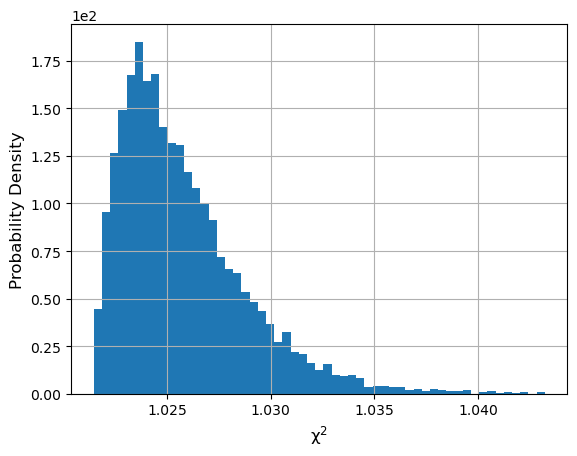

In [9]:
## Plots the reduced chi-squared distrubution 

plt.hist(chi2 / dof, bins = "fd", density = True, color = "tab:blue")
plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
plt.ylabel("Probability Density", fontsize = 12)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
plt.grid()
plt.show()

In [10]:
np.save("Q2_1500_hartlap_flat_samples.npy", flat_samples)
np.save("Q2_1500_hartlap_log_prob_samples.npy", log_prob_samples)